# RL-based system for assisting cab drivers for profit maximization
Cab drivers, like most people, are incentivised by a healthy growth in income. Many drivers complain that although their revenues are gradually increasing, their profits are almost flat. Thus, it is important that drivers choose the 'right' rides, i.e. choose the rides which are likely to maximise the total profit earned by the driver that day.  `The goal of this project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.`

We are imposing some assumptions and basic rules governing the ride-allocation system to minimize complexity. Rules are as follow:
* The taxis are electric cars. It can run for 30 days non-stop, i.e., 24*30 hrs. Then it needs to
recharge itself. If the cab driver is completing his trip at that time, he’ll finish that trip and
then stop for recharging. So, the terminal state is independent of the number of rides
covered in a month, it is achieved when the cab completes his 30 days, i.e., an episode is 30 days long
* There are only 5 locations in the city where the cab can operate.
* The decisions are made at an hourly interval; thus, the decision epochs are discrete. We won’t consider minutes and seconds for this project. So for example, the cab driver gets requests at 1:00 pm, then at 2:00 pm, then at 3:00 pm and so on. So, he can decide to pick among the requests only at these times. A request cannot come at (say) 2.30 pm.
* If the cab is already in use, then the driver won’t get any requests. Otherwise, he may get multiple request(s).
* He can either decide to take any one of these requests or can go ‘offline’, i.e., not accept any request at all. 
* The time taken to travel from one place to another is considered in integer hours (only) and
is dependent on the traffic. Also, the traffic is dependent on the hour of the day and the
day of the week.
* we have assumed that both the cost and the revenue are purely functions of time, i.e. for every hour of driving, the cost (of battery and other costs) and the revenue (from the customer) is the same - irrespective of the traffic conditions, speed of the car etc.


We have modelled our `environment as MDP process`, since as per our problem statement, the current state of environment (i.e. current state of game board) is suffiecient for taking future actions.

# Deep-RL Agent:
In this notebook, For reinforecemnt learning task, we will use `Deep Q-learning` for training our agent.
* Given the problem statement, We will Consider `Architecture 2` where Input is `State only` rather than state and action. In this architecture we just give state as the input to the NN and in return will get Q(s, a) for each action, so we have to run the NN just once for every state to take the action for which Q(s, a) is the maximum. This has advantage in real time scenarios.

In [1]:
# Importing CabDriver class from enviroment liabrary i.e importing the environment:
from Env import CabDriver

In [2]:
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# Importing other useful liabraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for plotting graphs
import matplotlib.pyplot as plt

#### Time Matrix:
*Time Matrix is designed on the basis of the historical data, considering the distance between two locations and traffic conditions, which generally depends on the hour of the day and the-day of the week.
* We will calculate the total time taken to reach from one point to other using this Time Matrix.
* Time Matrix is a 4-D matrix. The 4 dimensions are as below:
    • Start location (values: 0 to 4)
    • End location (values: 0 to 4)
    • Time of the day (values: 0 to 23)
    • Day of the week (values: 0 to 6)

In [3]:
# Loading the time matrix provided:
Time_matrix = np.load("TM.npy")

In [4]:
print(f'shape of time matrix : {Time_matrix.shape}')

shape of time matrix : (5, 5, 24, 7)


In [5]:
# Checking random value: (start location :0, end location =4, current time = 10,current day = 2)
print(Time_matrix[0][4][10][2])

3.0


### Agent Class

We will use following steps to define our agent class:
1. Defining State and Action Size
2. Defining Hyperparameters
3. Creating a neural-network model in function 'build_model()'
4. Defining epsilon-greedy strategy in function 'get_action()'
5. Defining the function 'append_sample()' to appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Defining the 'train_model()' function 

 #### Defining State and Action Size:
Since we are considering architecture 2:
* Dimenssion of input to the deep network i.e. state_size:
    * variables: 'm' i.e. location, 't' i.e current time(discrete values) and 'd' i.e. current day formulate the state of the environment. Since these values are categorical in nature (as per our problem formulation), we have used one hot encoding to represent each variable and thus ultimately the state of the environment. 
    * Thus `state_size = size of state vector = m + t + d = 5 + 24 + 7 = 36`
* Dimenssion of output of the deep network i.e. action_size:
    * output of deep network will be all possible actions i.e size of action space itself which is sum of all combinations of pickup and drop locations (20 such combinations) and one no-action(i.e. deciding to go offline action).
    * Thus `action_size = m * (m-1) + 1 = (5 * 4) + 1 = 21`
    
 #### Defining hyperparameters :
* Learning rate: 0.001
    * decides how much you want to update the existing value in accordance with the new value.
    * Very large Learning rate may result in unstable training where as very low value will take much longer training time
* Discount factor: 0.95
    * decides how much importance should be given to future rewards as the future is uncertain it's not always ideal to value your future rewards too much. It also helps to keep the reward bounded for continuous tasks.
    * High value means it will give higher importance to future rewards.
* epsilon_min = 0.00000001
    * Minimum value of ε. Cannot decay beyound this value
* epsilon_max = 1.0
    * Minimum value of ε
* epsilon_decay = 0.0004
    * Rate at which ε decays. Value should be selected such that balance between exploration and exploitation is achieved.
* batch_size = 128
    * Batch size to train the neural network in minibatches.
* memory = que of size 2000 elements
    * Size of the que type memory to store experiences after generating them to take random samples from later on, to break I.I.D nature of datapoints.
    
 #### Creating a neural-network model:
 * We will use deep neural-network for approximating Q(s,a) function.
 * Since our task is not that comples we will build smaller sequential model of i/p layer with 36 nodes, 2 hidden layers of 32 nodes each and o/p layer with 21 nodes.
 
#### Defining epsilon-greedy strategy in function 'get_action()':
* We will use Epsilon-greedy strategy for generating optimal policy. In Epsilon-greedy strategy, we generate the random number between 0 and 1 and depending upon the value of Epsilon, we take corresponding action: if value generated is less than Epsilon we take random action. But if value generated is more than epsilon we take the most greedy/optimal action.
* More the ε value, more will be exploration and less exploitation.
* Initially we want to explore more. But as we move towards the end of the RL training, we want to exploit the best policy. For this reason we will use decaying rate to achieve the balance between exploration and exploitation as there is a trade off between these two.

#### Defining the function 'append_sample()' to appends the recent experience:
* Before training the neural network to learn the state-value function, you need to have a data set that can be used for training. However, in reinforcement learning tasks, you generally don't have the data set.Before training the neural network to learn the state-value function, you need to have a data set that can be used for training. However, in reinforcement learning tasks, you generally don't have the data set. You are required to create a data set of the form (state,action,reward,new-state). 
* For this we will create append_sample() function so that recent encountered experiences are stored in the replay buffer.
* A neural network is trained in batches in which the data points are random (IID). But the agent's experience is generated sequentially, i.e. you go from one state to another state in a sequential, dependent fashion. So, to make a batch from a sequential process, you store them in memory and take random samples of batch size to break the I.I.D nature to be able to train the network.

#### Defining the 'train_model()' function:
* we will train the model with following logic:
   - If the memory size is greater than mini-batch size, we randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as encoded state and output batch as Q-values
      - Then fit DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    
    
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01       
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0015
        self.epsilon_min = 0.00000001
        self.batch_size = 32        
        self.memory = deque(maxlen=2000)  # create replay memory using deque
        
        # Initializing the states to later check for convergence  :
        
        ## Initializing the list to save value of the states tracked for incremental episodes:
        self.states_tracked_1 = []
        self.states_tracked_2 = []
        
        ## or Sample state-action pair 1: We are going to track state (2, 9, 1) and action (1,2) at index 5 in the action space.
        self.track_state_1 = env.state_encod_arch1((2, 9, 1)).reshape(1, self.state_size)
        ## For Sample state-action pair 2: We are going to track state (3, 19, 3) and action (2,3) at index 10 in the action space.
        self.track_state_2 = env.state_encod_arch1((3, 19, 3)).reshape(1, self.state_size)
        
        # creating model:
        self.model = self.build_model()

        
        
    # approximating Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        model.summary
        return model

    

    # getting an action from model using epsilon-greedy policy
    def get_action(self, state, episode):
        #For given state, getting possible actions that can be taken:
        possible_actions_index,actions = env.requests(state) 
        #epsilon decay implementation:
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode) 
        #getting an action as per epsilon-greedy policy:
        if np.random.rand() > epsilon:                  #condition for taking greedy action
            state_encod = env.state_encod_arch1(state)
            state_encod = state_encod.reshape(1, self.state_size)
            q_value = self.model.predict(state_encod)
            possible_q_value = [q_value[0][index] for index in possible_actions_index]
            action_index = possible_actions_index[np.argmax(possible_q_value)]
            action = env.action_space[action_index]
            return action_index,action
        else:                                           #condition for taking random action
            action_index = random.choice(possible_actions_index)
            action = env.action_space[action_index]
            return action_index,action
        
        
    
    # saving sample <s,a,r,s'> to the replay memory:
    def append_sample(self, state, action_index, reward, next_state, terminal_state):
        return self.memory.append((state, action_index, reward, next_state, terminal_state))
    
    
    
    # picking samples randomly from replay memory (with batch_size) and training the network:
    def train_model(self):
        #Start training only after there are enough datapoints in replay buffer:
        if len(self.memory) > self.batch_size:  
            # Sample batch from the memory randomly:
            mini_batch = random.sample(self.memory, self.batch_size)     
            # Initialise the variables update_input and update_target for a batch for storing the s and s':
            update_output = np.zeros((self.batch_size, self.state_size)) 
            update_input = np.zeros((self.batch_size, self.state_size)) 
            # lists action_indices, rewards, terminal_states contains action taken,reward obtained and terminal state at that timestep.
            action_indices, rewards, terminal_states = [], [], []
            
            # populate update_input and update_output and the lists rewards, actions, done:
            for i in range(self.batch_size):
                state, action_index, reward, next_state, terminal_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                action_indices.append(action_index)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                terminal_states.append(terminal_boolean)
                
            # Set the target as Q values predicted from the current state and next state
            # # store Q_t(S_t,a_t) and Q_t(S_{t+1},a) in target and target_val
            target = self.model.predict(update_input)
            target_qval = self.model.predict(update_output)
        
            # Update the target value according to the update policy of Q-learning
            # R_t + γ ∗ max Q_t(S_{t+1},a)−Q_t(S_t,a_t)
            for i in range(self.batch_size):
                if terminal_states[i]:   # for terminal state
                    target[i][action_indices[i]] = rewards[i]
                else: # for non-terminal state
                    target[i][action_indices[i]] = rewards[i] + self.discount_factor * (np.max(target_qval[i]))
                
            # model fit:
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

            
    # storing the q_values of the state we are tacking.        
    def save_tracking_states_q_value(self):
        # Using the model to predict the q_value of the state we are tacking.
        q_value_1 = self.model.predict(self.track_state_1)
        q_value_2 = self.model.predict(self.track_state_2)
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked_1.append(q_value_1[0][5])  # action (1,2) at index 5 in the action space
        self.states_tracked_2.append(q_value_2[0][10])  # action (1,4) at index 10 in the action space

        
    # save model weights     
    def save_weights(self, name):
        weights= self.model.get_weights()   # Gets model_weights as a list of numpy arrays
        try:
            fpkl= open(name, 'wb')
            pickle.dump(weights, fpkl, protocol= pickle.HIGHEST_PROTOCOL)  
            fpkl.close()
        except Exception as e:
            print(e)
        
        
    # save model    
    def save_model(self, name):
        self.model.save(name)    

In [7]:
# Initializing variables:
Episodes = 5000
m = 5 # number of cities
t = 24 # number of hours
d = 7  # number of days

# Creating an instance of an environment class:
env = CabDriver()
state_vector_size = m+t+d               ## Considering DQN_Architecture 2 (Input: State Only)
print("state_size:", state_vector_size)
action_size = len(env.action_space)
print("action_size:",action_size)

# Creating an instance of the agent class:
agent = DQNAgent(state_size=state_vector_size,action_size=action_size)
# Initializing list to track rewards for convergence checking:
episode_rewards = []

state_size: 36
action_size: 21


### DQN block

In [8]:
start_time = time.time()

for episode in range(Episodes):
    
    # Initializing flags and necessary variables:
    terminal_state = False       #Terminal condition flag
    total_reward = 0             #Total reward in this episode
    
    # Reset at the start of each episode
    env = CabDriver()
    state_space, action_space, state = env.reset()
    
    while terminal_state != True:
        # Pick an action as per epsilon-greedy policy from possible actions for the current state:
        action_index,action = agent.get_action(state,episode)
        # Evaluating reward based on action taken and Time_matrix.
        reward = env.reward_func(state,action,Time_matrix)
        # Evaluating next state based on action taken from the current state and whether episode has terminated or not:
        next_state,terminal_state = env.next_state_func(state, action, Time_matrix)
        # Appending the generated experience <state, action, reward, next state, terminal state> to the memory:
        agent.append_sample(state, action_index, reward, next_state, terminal_state)
        # Training the model by calling function agent.train_model:
        agent.train_model()
        # updating the total reward :
        total_reward += reward
        # updating the current state:
        state = next_state

    # Storing the total reward obtained in this episode:
    episode_rewards.append(total_reward)
    
    # Save the Q_value of the state-action pair we are tracking (every 10 episodes):
    if ((episode+1) % 10) == 0:   
        agent.save_tracking_states_q_value()
        
   # Saving the model weights every 500th episode:
    if ((episode+1)% 500) == 0:  
        print(f'saving the model at episode checkpoint:{episode+1}')
        agent.save_weights('model_weights.pkl')
        
    if ((episode+1)% 200) == 0:  
        print(f'episodes completed:{episode+1}')
        

# Saving the final model weights after completion of training:
agent.save_weights('model_weights.pkl')
# Saving the final model :
agent.save_model('DQN_model.h5')

elapsed_time = time.time() - start_time
print('Run time: ', elapsed_time)

episodes completed:200
episodes completed:400
saving the model at episode checkpoint:500
episodes completed:600
episodes completed:800
saving the model at episode checkpoint:1000
episodes completed:1000
episodes completed:1200
episodes completed:1400
saving the model at episode checkpoint:1500
episodes completed:1600
episodes completed:1800
saving the model at episode checkpoint:2000
episodes completed:2000
episodes completed:2200
episodes completed:2400
saving the model at episode checkpoint:2500
episodes completed:2600
episodes completed:2800
saving the model at episode checkpoint:3000
episodes completed:3000
episodes completed:3200
episodes completed:3400
saving the model at episode checkpoint:3500
episodes completed:3600
episodes completed:3800
saving the model at episode checkpoint:4000
episodes completed:4000
episodes completed:4200
episodes completed:4400
saving the model at episode checkpoint:4500
episodes completed:4600
episodes completed:4800
saving the model at episode check

### Tracking Convergence

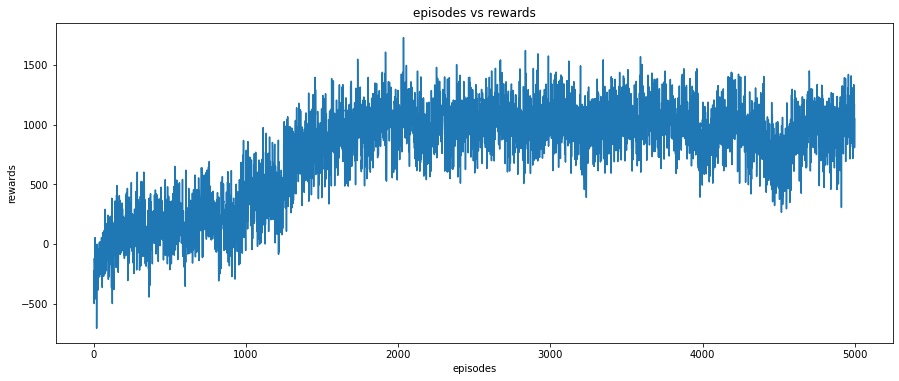

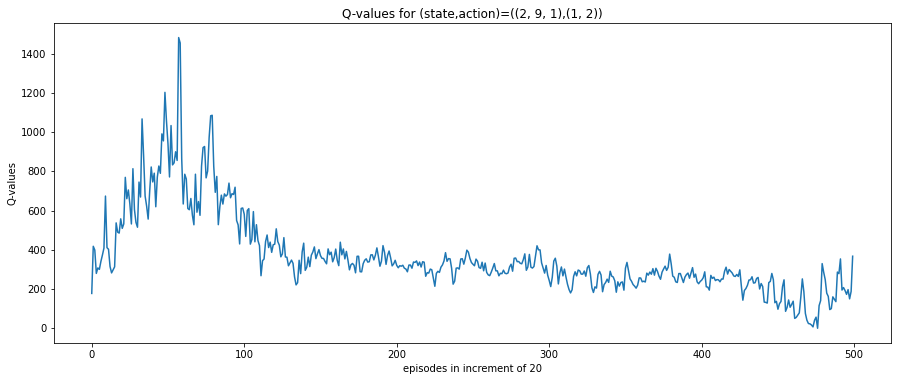

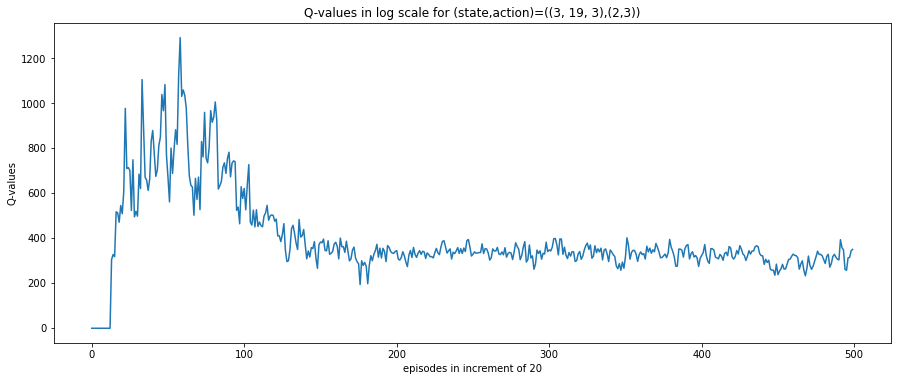

In [9]:
plt.figure(figsize=[15,20])
plt.subplot(3, 1, 1)
x_axis = np.asarray(range(0, len(episode_rewards)))
y_axis = episode_rewards
plt.title("episodes vs rewards")
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.plot(x_axis,y_axis)


plt.figure(figsize=[15,20])
plt.subplot(3, 1, 2)
x_axis = np.asarray(range(0, len(agent.states_tracked_1)))
y_axis = agent.states_tracked_1
plt.title("Q-values for (state,action)=((2, 9, 1),(1, 2))")
plt.xlabel('episodes in increment of 20')
plt.ylabel('Q-values')
plt.plot(x_axis,y_axis)


plt.figure(figsize=[15,20])
plt.subplot(3, 1, 3)
x_axis = np.asarray(range(0, len(agent.states_tracked_2)))
y_axis = agent.states_tracked_2
plt.title("Q-values in log scale for (state,action)=((3, 19, 3),(2,3))")
plt.xlabel('episodes in increment of 20')
plt.ylabel('Q-values')
plt.plot(x_axis,y_axis)

plt.show()

We can see that as number of episodes increases, q value converges for tracked states.
Also, as the number of trained episodes are increasing, reward is also increasing and stabalizes near the end.
Thus convergence is achieved.

#### Using the trained RL agent for selecting optimum action given the state:

In [10]:
# loading the model
from keras.models import load_model
model = load_model('DQN_model.h5')  

In [11]:
# Creating a function to make model predictions:
def optimum_action(state, state_size= m+t+d):
    env = CabDriver()
    # Converting state to corresponding vector
    state_encoded= env.state_encod_arch1(state).reshape(1, state_size)
    # Predict the action for given state
    action= env.action_space[np.argmax(model.predict(state_encoded))]
    
    print(f"Predicted action corresponding to state {state} is {action}:")

In [12]:
# according to the trained model, the optimum action from given state is as follow:
optimum_action(state=(0,0,0))
optimum_action(state=(1,10,2))

Predicted action corresponding to state (0, 0, 0) is (1, 2):
Predicted action corresponding to state (1, 10, 2) is (1, 2):


#### Epsilon-decay function to decide suitable decay rate:

In [13]:
max_epsilon = 1.0
min_epsilon = 0.00000001
episodes = 5000
epsilon_decay = 0.0015
time = np.arange(0,episodes)
epsilon = []
for i in range(0,episodes):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay*i))

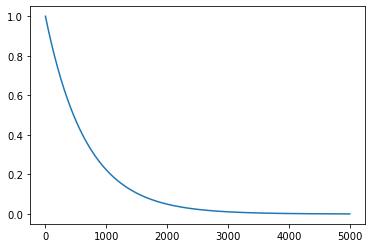

In [14]:
plt.plot(time, epsilon)
plt.show()